# Python BANA Project
## By: Mohammad Zain Khaishagi (M13457536)

In [1]:
#%tensorflow_version 2.x
%tensorflow_version 1.x 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds


TensorFlow 1.x selected.


In [0]:
# List of potential datasets to use:
# Childrens' Books https://github.com/HendrikStrobelt/LSTMVis
# Wikihow https://github.com/mahnazkoupaee/WikiHow-Dataset
# Wikipedia https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/


In [0]:
# import requests

# url = 'https://raw.githubusercontent.com/GradySimon/tensorflow-glove/6a05b0545283cb2e576f2286e5dca11a1e42bbb9/tf_glove.py'
# r = requests.get(url, allow_redirects=True)
# open('tf_glove.py', 'wb').write(r.content)

# import tf_glove

# model = tf_glove.GloVeModel(embedding_size=50, context_size=10, min_occurrences=25,
#                             learning_rate=0.05, batch_size=512)

In [0]:
# Updated tf_glove to remove the following warnings

# WARNING:tensorflow:From /content/tf_glove.py:69: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

# WARNING:tensorflow:From /content/tf_glove.py:77: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

# WARNING:tensorflow:From /content/tf_glove.py:96: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
# Instructions for updating:
# Deprecated in favor of operator or tf.math.divide.
# WARNING:tensorflow:From /content/tf_glove.py:101: The name tf.log is deprecated. Please use tf.math.log instead.

# WARNING:tensorflow:From /content/tf_glove.py:101: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
# Instructions for updating:
# Use `tf.cast` instead.
# WARNING:tensorflow:From /content/tf_glove.py:111: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

# WARNING:tensorflow:From /content/tf_glove.py:112: The name tf.train.AdagradOptimizer is deprecated. Please use tf.compat.v1.train.AdagradOptimizer instead.

# WARNING:tensorflow:From /tensorflow-1.15.2/python3.6/tensorflow_core/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
# Instructions for updating:
# Call initializer instance with the dtype argument instead of passing it to the constructor
# WARNING:tensorflow:From /content/tf_glove.py:114: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



from __future__ import division
from collections import Counter, defaultdict
import os
from random import shuffle
import tensorflow as tf


class NotTrainedError(Exception):
    pass

class NotFitToCorpusError(Exception):
    pass

class GloVeModel():
    def __init__(self, embedding_size, context_size, max_vocab_size=100000, min_occurrences=1,
                 scaling_factor=3/4, cooccurrence_cap=100, batch_size=512, learning_rate=0.05):
        self.embedding_size = embedding_size
        if isinstance(context_size, tuple):
            self.left_context, self.right_context = context_size
        elif isinstance(context_size, int):
            self.left_context = self.right_context = context_size
        else:
            raise ValueError("`context_size` should be an int or a tuple of two ints")
        self.max_vocab_size = max_vocab_size
        self.min_occurrences = min_occurrences
        self.scaling_factor = scaling_factor
        self.cooccurrence_cap = cooccurrence_cap
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.__words = None
        self.__word_to_id = None
        self.__cooccurrence_matrix = None
        self.__embeddings = None

    def fit_to_corpus(self, corpus):
        self.__fit_to_corpus(corpus, self.max_vocab_size, self.min_occurrences,
                             self.left_context, self.right_context)
        self.__build_graph()

    def __fit_to_corpus(self, corpus, vocab_size, min_occurrences, left_size, right_size):
        word_counts = Counter()
        cooccurrence_counts = defaultdict(float)
        for region in corpus:
            word_counts.update(region)
            for l_context, word, r_context in _context_windows(region, left_size, right_size):
                for i, context_word in enumerate(l_context[::-1]):
                    # add (1 / distance from focal word) for this pair
                    cooccurrence_counts[(word, context_word)] += 1 / (i + 1)
                for i, context_word in enumerate(r_context):
                    cooccurrence_counts[(word, context_word)] += 1 / (i + 1)
        if len(cooccurrence_counts) == 0:
            raise ValueError("No coccurrences in corpus. Did you try to reuse a generator?")
        self.__words = [word for word, count in word_counts.most_common(vocab_size)
                        if count >= min_occurrences]
        self.__word_to_id = {word: i for i, word in enumerate(self.__words)}
        self.__cooccurrence_matrix = {
            (self.__word_to_id[words[0]], self.__word_to_id[words[1]]): count
            for words, count in cooccurrence_counts.items()
            if words[0] in self.__word_to_id and words[1] in self.__word_to_id}

    def __build_graph(self):
        self.__graph = tf.Graph()
        with self.__graph.as_default(), self.__graph.device(_device_for_node):
            count_max = tf.constant([self.cooccurrence_cap], dtype=tf.float32,
                                    name='max_cooccurrence_count')
            scaling_factor = tf.constant([self.scaling_factor], dtype=tf.float32,
                                         name="scaling_factor")

            self.__focal_input = tf.compat.v1.placeholder(tf.int32, shape=[self.batch_size],
                                                name="focal_words")
            self.__context_input = tf.compat.v1.placeholder(tf.int32, shape=[self.batch_size],
                                                  name="context_words")
            self.__cooccurrence_count = tf.compat.v1.placeholder(tf.float32, shape=[self.batch_size],
                                                       name="cooccurrence_count")

            focal_embeddings = tf.Variable(
                tf.random.uniform([self.vocab_size, self.embedding_size], 1.0, -1.0),
                name="focal_embeddings")
            context_embeddings = tf.Variable(
                tf.random.uniform([self.vocab_size, self.embedding_size], 1.0, -1.0),
                name="context_embeddings")

            focal_biases = tf.Variable(tf.random.uniform([self.vocab_size], 1.0, -1.0),
                                       name='focal_biases')
            context_biases = tf.Variable(tf.random.uniform([self.vocab_size], 1.0, -1.0),
                                         name="context_biases")

            focal_embedding = tf.nn.embedding_lookup([focal_embeddings], self.__focal_input)
            context_embedding = tf.nn.embedding_lookup([context_embeddings], self.__context_input)
            focal_bias = tf.nn.embedding_lookup([focal_biases], self.__focal_input)
            context_bias = tf.nn.embedding_lookup([context_biases], self.__context_input)

            weighting_factor = tf.minimum(
                1.0,
                tf.pow(
                    tf.math.divide(self.__cooccurrence_count, count_max),
                    scaling_factor))

            embedding_product = tf.reduce_sum(tf.multiply(focal_embedding, context_embedding), 1)

            log_cooccurrences = tf.math.log(tf.cast(self.__cooccurrence_count, dtype=tf.float32))

            distance_expr = tf.square(tf.add_n([
                embedding_product,
                focal_bias,
                context_bias,
                tf.negative(log_cooccurrences)]))

            single_losses = tf.multiply(weighting_factor, distance_expr)
            self.__total_loss = tf.reduce_sum(single_losses)
            tf.compat.v1.summary.scalar("GloVe_loss", self.__total_loss)
            self.__optimizer = tf.compat.v1.train.AdagradOptimizer(self.learning_rate).minimize(
                self.__total_loss)
            self.__summary = tf.compat.v1.summary.merge_all()

            self.__combined_embeddings = tf.add(focal_embeddings, context_embeddings,
                                                name="combined_embeddings")

    def train(self, num_epochs, log_dir=None, summary_batch_interval=1000,
              tsne_epoch_interval=None):
        should_write_summaries = log_dir is not None and summary_batch_interval
        should_generate_tsne = log_dir is not None and tsne_epoch_interval
        batches = self.__prepare_batches()
        total_steps = 0
        with tf.Session(graph=self.__graph) as session:
            if should_write_summaries:
                print("Writing TensorBoard summaries to {}".format(log_dir))
                summary_writer = tf.summary.FileWriter(log_dir, graph=session.graph)
            tf.global_variables_initializer().run()
            for epoch in range(num_epochs):
                shuffle(batches)
                for batch_index, batch in enumerate(batches):
                    i_s, j_s, counts = batch
                    if len(counts) != self.batch_size:
                        continue
                    feed_dict = {
                        self.__focal_input: i_s,
                        self.__context_input: j_s,
                        self.__cooccurrence_count: counts}
                    session.run([self.__optimizer], feed_dict=feed_dict)
                    if should_write_summaries and (total_steps + 1) % summary_batch_interval == 0:
                        summary_str = session.run(self.__summary, feed_dict=feed_dict)
                        summary_writer.add_summary(summary_str, total_steps)
                    total_steps += 1
                if should_generate_tsne and (epoch + 1) % tsne_epoch_interval == 0:
                    current_embeddings = self.__combined_embeddings.eval()
                    output_path = os.path.join(log_dir, "epoch{:03d}.png".format(epoch + 1))
                    self.generate_tsne(output_path, embeddings=current_embeddings)
            self.__embeddings = self.__combined_embeddings.eval()
            if should_write_summaries:
                summary_writer.close()

    def embedding_for(self, word_str_or_id):
        if isinstance(word_str_or_id, str):
            return self.embeddings[self.__word_to_id[word_str_or_id]]
        elif isinstance(word_str_or_id, int):
            return self.embeddings[word_str_or_id]

    def __prepare_batches(self):
        if self.__cooccurrence_matrix is None:
            raise NotFitToCorpusError(
                "Need to fit model to corpus before preparing training batches.")
        cooccurrences = [(word_ids[0], word_ids[1], count)
                         for word_ids, count in self.__cooccurrence_matrix.items()]
        i_indices, j_indices, counts = zip(*cooccurrences)
        return list(_batchify(self.batch_size, i_indices, j_indices, counts))

    @property
    def vocab_size(self):
        return len(self.__words)

    @property
    def words(self):
        if self.__words is None:
            raise NotFitToCorpusError("Need to fit model to corpus before accessing words.")
        return self.__words

    @property
    def embeddings(self):
        if self.__embeddings is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__embeddings

    def id_for_word(self, word):
        if self.__word_to_id is None:
            raise NotFitToCorpusError("Need to fit model to corpus before looking up word ids.")
        return self.__word_to_id[word]

    def generate_tsne(self, path=None, size=(100, 100), word_count=1000, embeddings=None):
        if embeddings is None:
            embeddings = self.embeddings
        from sklearn.manifold import TSNE
        tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
        low_dim_embs = tsne.fit_transform(embeddings[:word_count, :])
        labels = self.words[:word_count]
        return _plot_with_labels(low_dim_embs, labels, path, size)


def _context_windows(region, left_size, right_size):
    for i, word in enumerate(region):
        start_index = i - left_size
        end_index = i + right_size
        left_context = _window(region, start_index, i - 1)
        right_context = _window(region, i + 1, end_index)
        yield (left_context, word, right_context)


def _window(region, start_index, end_index):
    """
    Returns the list of words starting from `start_index`, going to `end_index`
    taken from region. If `start_index` is a negative number, or if `end_index`
    is greater than the index of the last word in region, this function will pad
    its return value with `NULL_WORD`.
    """
    last_index = len(region) + 1
    selected_tokens = region[max(start_index, 0):min(end_index, last_index) + 1]
    return selected_tokens


def _device_for_node(n):
    if n.type == "MatMul":
        return "/gpu:0"
    else:
        return "/cpu:0"


def _batchify(batch_size, *sequences):
    for i in range(0, len(sequences[0]), batch_size):
        yield tuple(sequence[i:i+batch_size] for sequence in sequences)


def _plot_with_labels(low_dim_embs, labels, path, size):
    import matplotlib.pyplot as plt
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    figure = plt.figure(figsize=size)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right',
                     va='bottom')
    if path is not None:
        figure.savefig(path)
        plt.close(figure)


In [115]:
from bs4 import BeautifulSoup

url = 'http://paulgraham.com/useful.html'
page = requests.get(url)
print(page)
soup = BeautifulSoup(page.text, "html.parser")
tags = soup.findAll("font")


<Response [200]>


In [0]:
a=[]
i=0
for tag in tags:
  a.append(tag.get_text())
text=a[0]

In [0]:
import nltk
corpus = nltk.regexp_tokenize(text.lower(), pattern='\w+|\$[\d\.]+|\S+')

In [0]:
corpus = [x for x in corpus if len(x)>2]
corpus[0:20]
x=[]
x.append(corpus)
x.append(corpus)
corpus=x

In [0]:
model = GloVeModel(embedding_size=50, context_size=100, min_occurrences=4, learning_rate=0.05, batch_size=512)
model.fit_to_corpus(corpus)

In [130]:
model.train(num_epochs=500, log_dir="log/example", summary_batch_interval=1000)

Writing TensorBoard summaries to log/example


In [133]:
model.vocab_size

303

In [75]:
model.embeddings

array([[-0.02554252, -1.4344716 ,  0.63845026, ..., -1.6422447 ,
        -0.1380338 , -1.9674468 ],
       [-2.2289033 , -0.37411827,  1.4657949 , ..., -1.0617523 ,
         0.04317585, -0.54148746],
       [ 0.26779097,  0.6252788 ,  0.325816  , ..., -1.2154771 ,
         0.7243074 , -0.31802392],
       ...,
       [ 0.02260017,  1.4766586 ,  1.3714261 , ..., -1.5695415 ,
         0.9150939 ,  0.08211589],
       [-0.5038588 ,  1.294168  , -0.06720066, ...,  0.94072485,
         0.4814663 ,  0.22750068],
       [ 0.73578095, -0.998894  ,  0.33032727, ..., -0.3229537 ,
         1.3114231 ,  1.3176494 ]], dtype=float32)

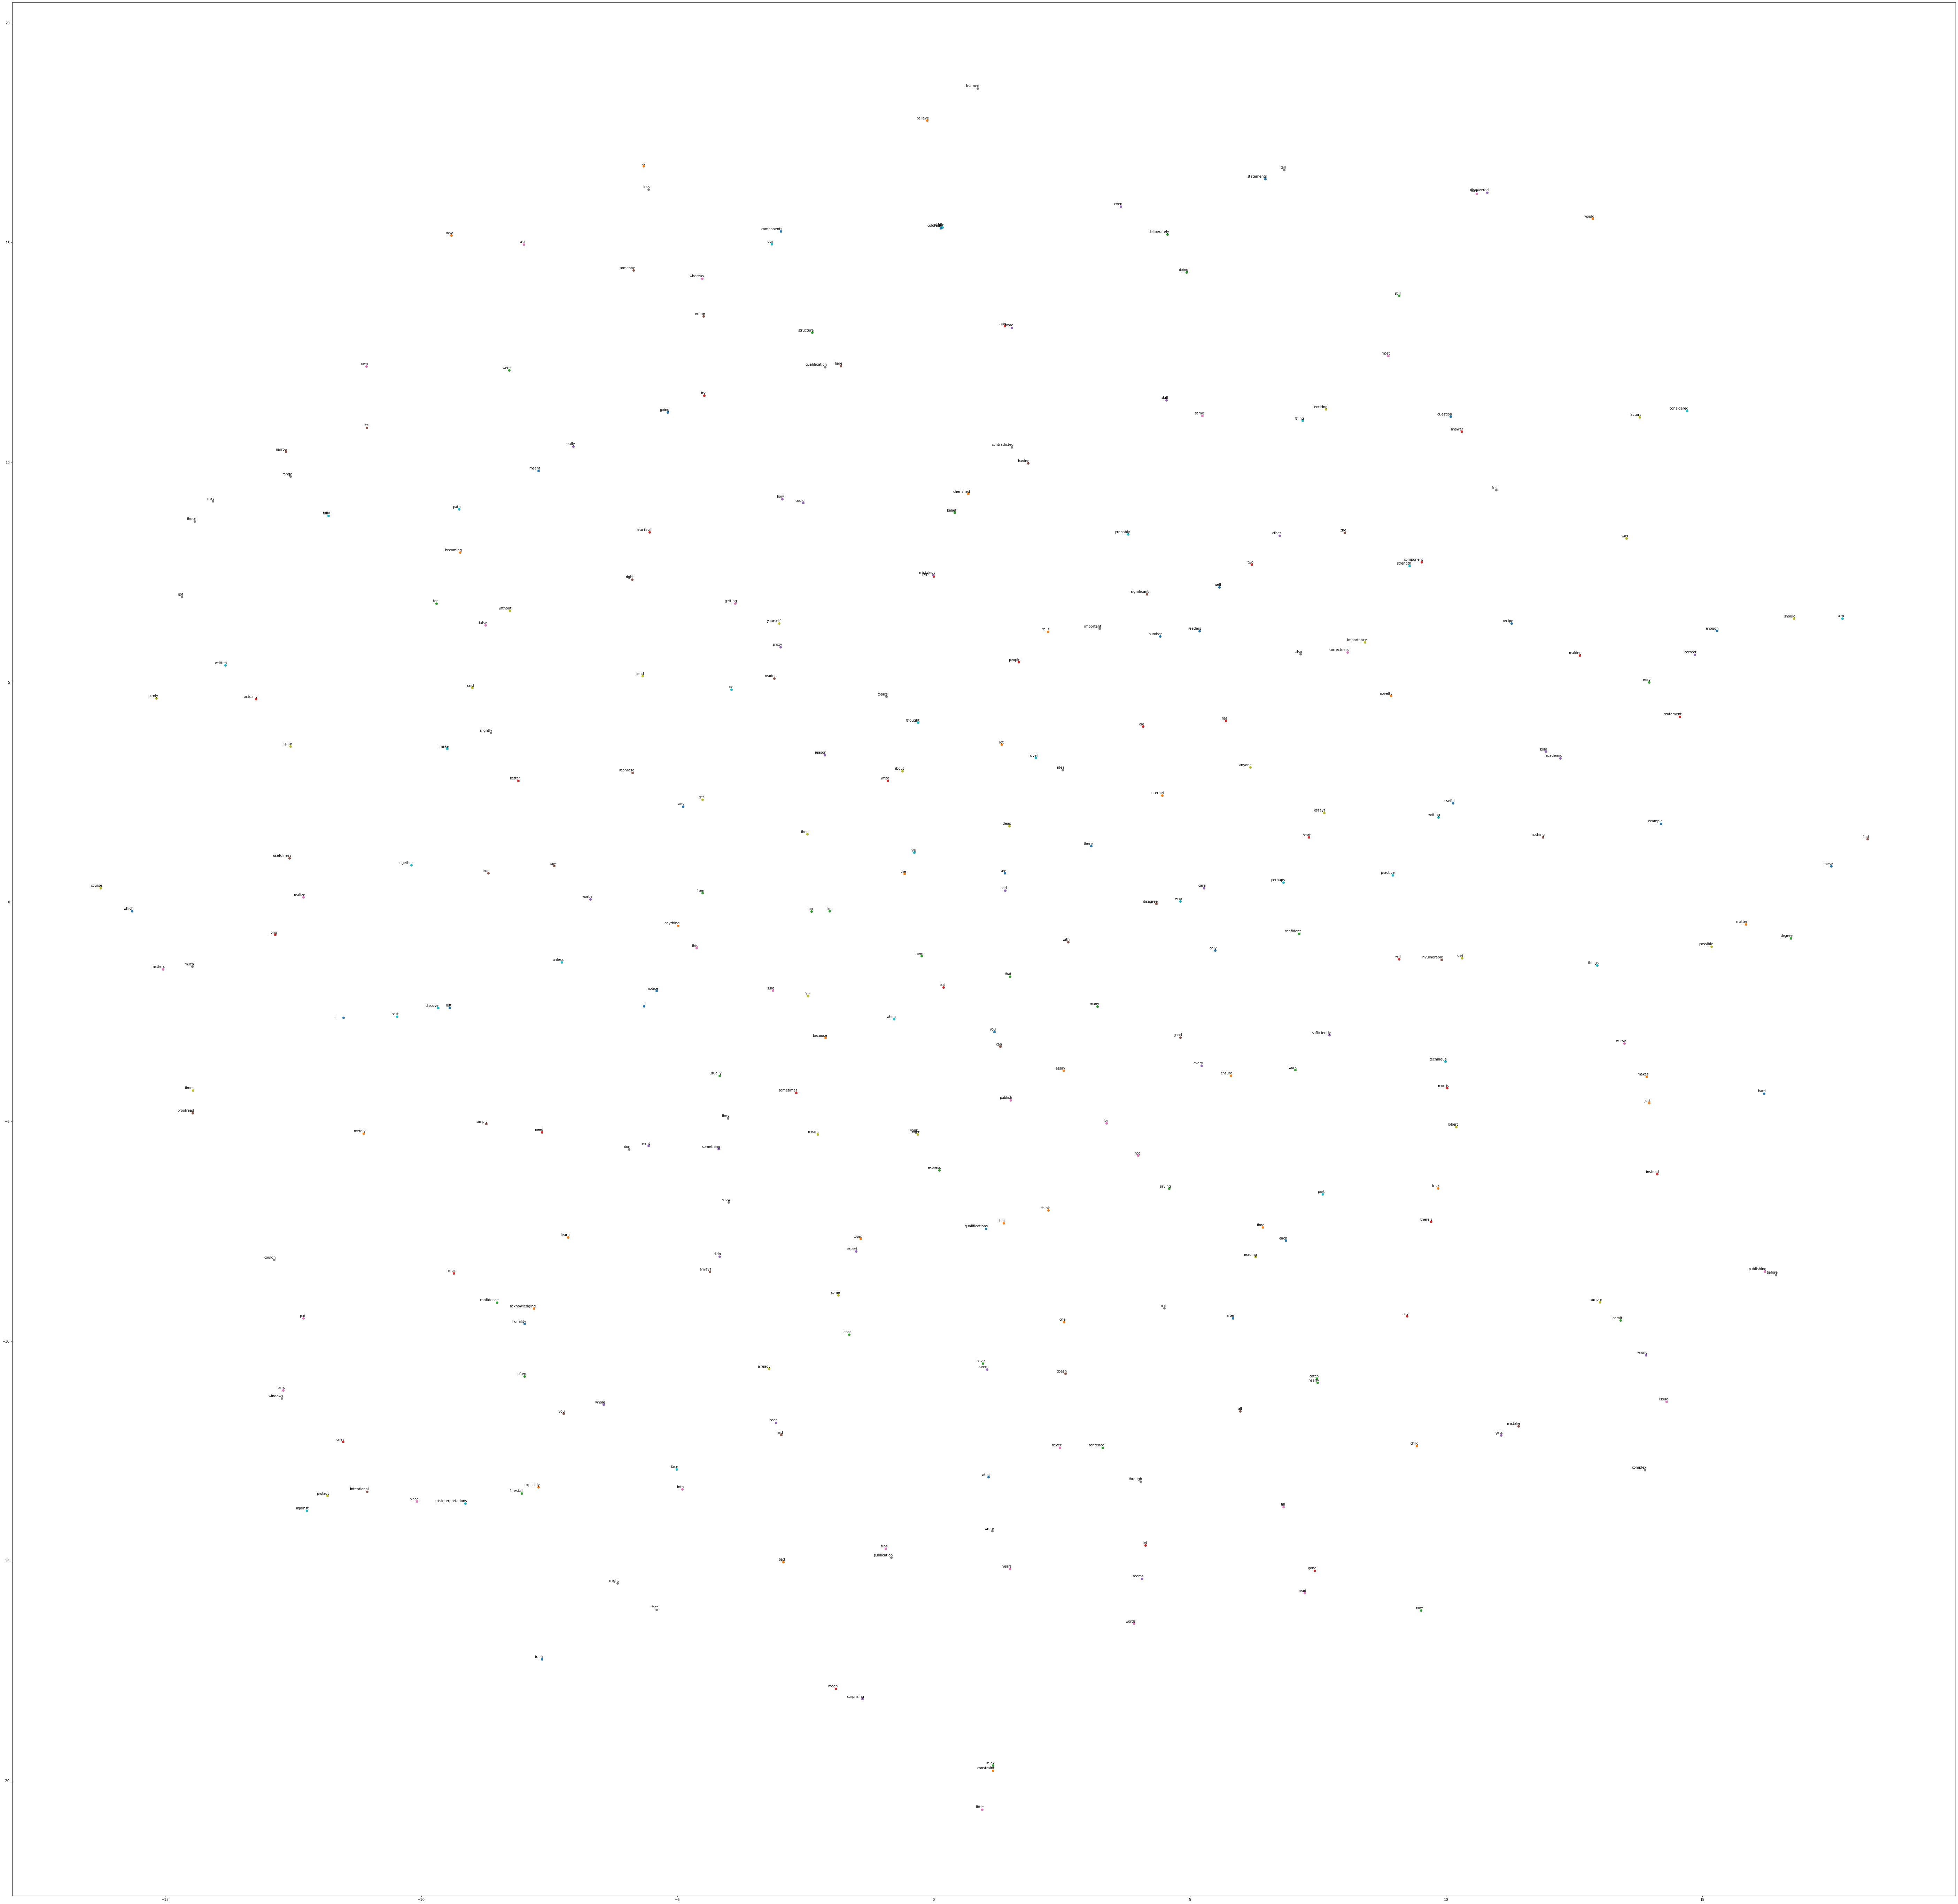

In [134]:
%matplotlib inline
model.generate_tsne()